# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
dir_save = '/home/rich/Desktop/'

In [4]:
params = {
    'paths': {
        'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',  ## directory where ROICat is
        'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16",  ## directory where directories containing below 'pathSuffixTo...' are
        'pathSuffixToStat': 'plane0/stat.npy',  ## path suffix to where the stat.npy file is
        'pathSuffixToOps': 'plane0/ops.npy',  ## path suffix to where the ops.npy file is
        'dir_save': r'/home/rich/Desktop/',  ## default: None. Directory to save output file to. If None then saves in dir_allOuterFolders.
        'filenamePrefix_save': None,  ##  default: None. Filename prefix to save results to. If None then just uses the dir_allOuterFolders.name.
    },
    'importing': {
        'data_verbose': True,  ## default: True. Whether to print out data importing information
        'out_height_width': [72, 72],  ## default: [36,36]. Height and width of small cropped output images of each ROI.
        'max_footprint_width': 1025,  ## default: 1025. Maximum length of a spatial footprint. If you get an error during importing, try increasing this value.
        'type_meanImg': 'meanImgE',  ## default: 'meanImgE'. Type of mean image to use for normalization. This is just a field in the ops.npy file.
        'um_per_pixel': 1.0,  ## default: 1.0. Number of microns per pixel for the imaging dataset. Doesn't need to be exact. Used for resizing the ROIs. Check the images of the resized ROIs to tweak.
        'new_or_old_suite2p': 'new',  ## default: 'new'. If using suite2p, this specifices whether the stat.npy file is in the old MATLAB format or new Python format.
        'images': None,  ## default: None. Set to None if you want to use the images extracted from Suite2p
        'import_workers': -1, ## default: -1. Number of workers to use for importing. Set to -1 to use all available workers.
    },
    'alignment': {
        'session_template': 0.5,  ## default: 0.5. Which session to use as a registration template. If input is float (ie 0.0, 0.5, 1.0, etc.), then it is the fractional position of the session to use; if input is int (ie 1, 2, 3), then it is the index of the session to use (0-indexed)
        'phaseCorr': {
            'freq_highPass': 0.01,  ## default: 0.01. Spatial frequency upper-bound cut-off to use for phase correlation. Spatial frequencies correlations higher than this will be set to zero.
            'freq_lowPass': 0.3,  ## default: 0.3. Spatial frequency lower-bound cut-off to use for phase correlation. Spatial frequencies correlations lower than this will be set to zero.
        },
        'method': 'createOptFlow_DeepFlow',  ## default: 'createOptFlow_DeepFlow'. Method to use for creating optical flow.
        'kwargs_method': None,  ## default: None. Keyword arguments to pass to the cv2 optical flow method.
        'use_CLAHE': False,  ## default: False. Whether or not to use 'Contrast Limited Adaptive Histogram Equalization'. Useful if params['importing']['type_meanImg'] is not a contrast enhanced image (like 'meanImgE' in Suite2p)
        'return_sparse': True,  ## default: True. Whether to return a sparse matrix (True) or a dense matrix (False).
        'normalize': True,  ## default: True. If True, normalize the spatial footprints to have a sum of 1.
    },
    'blurring': {
        'kernel_halfWidth': 4.0,  ## default: 2.0. Half-width of the cosine kernel used for blurring. Set value based on how much you think the ROIs move from session to session.
        'plot_kernel': False,  ## default: False. Whether to plot the kernel used for blurring.
    },
    'ROInet': {
        'device': 'cuda:0',  ## default: 'cuda:0'. Device to use for ROInet. Recommend using a GPU.
        'hash_dict_true': {
            'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
            'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
            'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
        },
        'dir_networkFiles': '/home/rich/Downloads/ROInet',  ## local directory where network files are stored
        'download_from_gDrive': 'check_local_first',  ## default: 'check_local_first'. Whether to download the network files from Google Drive or to use the local files.
        'gDriveID': '1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',  ## default: '1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8'. Google Drive ID of the network files.
        'forward_pass_version': 'latent', # default: 'latent'. Leave as 'latent' for most things. Can be 'latent' (full pass through network), 'head' (output of the head layers), or 'base' (pass through just base layers)
        'verbose': True,  ## default: True. Whether to print out ROInet information.
        'pref_plot': False,  ## default: False. Whether to plot the ROI and the normalized ROI.
        'batchSize_dataloader': 8,  ## default: 8. Number of images to use for each batch.
        'pinMemory_dataloader': True,  ## default: True. Whether to pin the memory of the dataloader.
        'persistentWorkers_dataloader': True,  ## default: True. Whether to use persistent workers for the dataloader.
        'prefetchFactor_dataloader': 2,  ## default: 2. Number of prefetch factors to use for the dataloader.
    },
    'SWT': {
        'kwargs_Scattering2D': {'J': 2, 'L': 2},  ## default: {'J': 2, 'L': 8}. Keyword arguments to pass to the Scattering2D function.
        'device': 'cuda:0',  ## default: 'cuda:0'. Device to use for SWT. Recommend using a GPU.
    }, 
    'similarity': {
        'spatialFootprint_maskPower': 1.0,  ## default: 1.0. This determines the power to take the ROI mask images to. Higher for more dependent on brightness, lower for more dependent on binary overlap.
        'n_workers': -1,  ## default: -1. Number of workers to use for similarity. Set to -1 to use all available workers.
        'block_height': 1024,  ## default: 64. Maximum height of the FOV block bins to use for pairwise ROI similarity calculations. Use smaller values (16-64) if n_sessions is large (<12), else keep around (64-128)
        'block_width': 1024,  ## default: 64. Maximum width of the FOV block bins to use for pairwise ROI similarity calculations. Use smaller values (16-64) if n_sessions is large (<12), else keep around (64-128)
        'algorithm_nearestNeigbors_spatialFootprints': 'brute',  ## default: 'brute'. Algorithm to use for nearest neighbors.
        'verbose': True,  ## default: True. Whether to print out similarity information.
        'normalization': {
            'k_max': 4000,  ## default: 4000. Maximum kNN distance to use for building a distribution of pairwise similarities for each ROI.
            'k_min': 150,  ## default: 150. Set around n_sessions*10. Minimum kNN distance to use for building a distribution of pairwise similarities for each ROI. 
            'algo_NN': 'kd_tree',
        },
    },
    ## Cluster
    'clustering': {
        'power_sf': 1,  ## default: 1. Power to which to raise the spatial footprint similarity. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'power_NN': 2,  ## default: 2. Power to which to raise the spatial neural network similarity. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'power_SWT': 0.1,  ## default: 0.1. Power to which to raise the scattering wavelet transform similarity. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'p_norm': -1,  ## default: -1. p-norm to use for the conjunction of the similarity matrices into a single matrix. Higher values are more conjunctive (more like s_sf * s_NN), and lower values are more permissive (more like s_sf + s_NN)
        'sig_NN_kwargs': {'mu':0.0, 'b':0.5},  ## default: {'mu':0.0, 'b':0.5}. 'mu' tunes the center, 'b' tunes the sharpness of the sigmoid function applied. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'sig_SWT_kwargs': {'mu':0.0, 'b':0.5},  ## default: {'mu':0.0, 'b':0.5}. 'mu' tunes the center, 'b' tunes the sharpness of the sigmoid function applied. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'n_bins': 100,  ## default: 50. Number of bins to use to create a histogram for determining the cut-off distance for the pairwise distance. Tune by looking at the clusterer.plot_similarity_relationships() plots.
        'smoothing_window': 8,  ## default: 8. Number of bins to use as the smoothing window for a savgol_filter. Use smaller distances (3-8) for large datasets (>30k total ROIs), and larger distances (10-20) for smaller datasets.
        'plot_pref': True,  ## default: True. Whether or not to plot things related to clustering.
        'min_cluster_size': 2,  ## default: 2. Smallest allowable cluster size.
        'discard_failed_pruning': True,  ## default: True. Best to leave as True. If the clustering can't find a way to separate clusters with multiple ROIs from the same session, just discard those clusters. Leaving as True shouldn't affect results. Send issue report if it does.
    },
    'visualization': {
        'FOV_threshold_confidence': 0.0,  ## default: 0.0. Threshold for the confidence scores when displaying ROIs.
    },
}

In [5]:
dir_github = Path(params['paths']['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

In [6]:
# params_all = [helpers.deep_update_dict(params, ['paths', 'dir_allOuterFolders'], val) for val in [
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp6_3",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp11",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp12",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp13",
#         r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16",
# ]]

In [ ]:
# %matplotlib notebook


# Import paths
def print_list(l):
    for item in l:
        print(item)

dir_allOuterFolders = Path(params['paths']['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['paths']['pathSuffixToStat']
pathSuffixToOps = params['paths']['pathSuffixToOps']

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)


#Import data
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=params['importing']['um_per_pixel'],    
    new_or_old_suite2p=params['importing']['new_or_old_suite2p'],
    verbose=params['importing']['data_verbose'],
);

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=params['importing']['out_height_width'],
    max_footprint_width=params['importing']['max_footprint_width'],
);

data.import_FOV_images(
    type_meanImg=params['importing']['type_meanImg'],
    images=params['importing']['images'],
);

data.import_ROI_spatialFootprints(workers=params['importing']['import_workers']);

# visualization.display_toggle_image_stack(data.FOV_images)


# Alignment
FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if params['alignment']['use_CLAHE'] else data.FOV_images
st = params['alignment']['session_template']
idx_st = int(st * data.n_sessions) if type(st) is float else st


pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=params['alignment']['phaseCorr']['freq_highPass'],
    freq_lowPass=params['alignment']['phaseCorr']['freq_lowPass'],
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    im_template=FOV_images[idx_st],
    ims_moving=FOV_images
);

In [10]:
aligner = alignment.Alinger(
    method=params['alignment']['method'],
    kwargs_method=params['alignment']['kwargs_method'],
)

aligner.register_ROIs(
    templateFOV=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    shifts=pcr.shifts,
    return_sparse=params['alignment']['return_sparse'],
    normalize=params['alignment']['normalize'],
);

# visualization.display_toggle_image_stack(pcr.ims_registered[:])

# visualization.display_toggle_image_stack(aligner.FOVs_aligned)
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
# visualization.display_toggle_2channel_image_stack(aligner.flows)

100%|███████████████████████████████████████████| 14/14 [04:35<00:00, 19.65s/it]


<IPython.core.display.Javascript object>


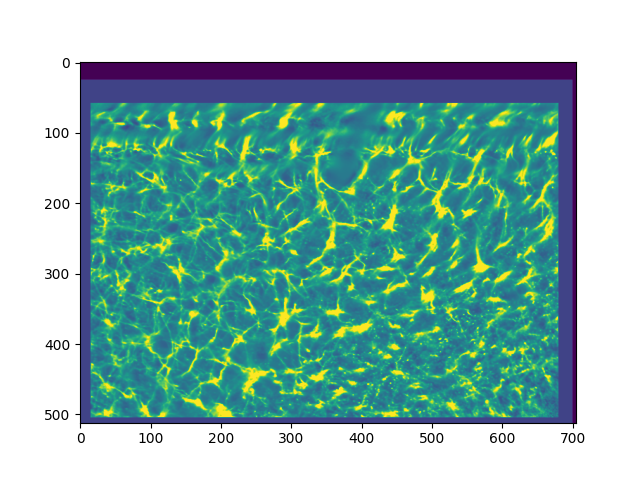

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


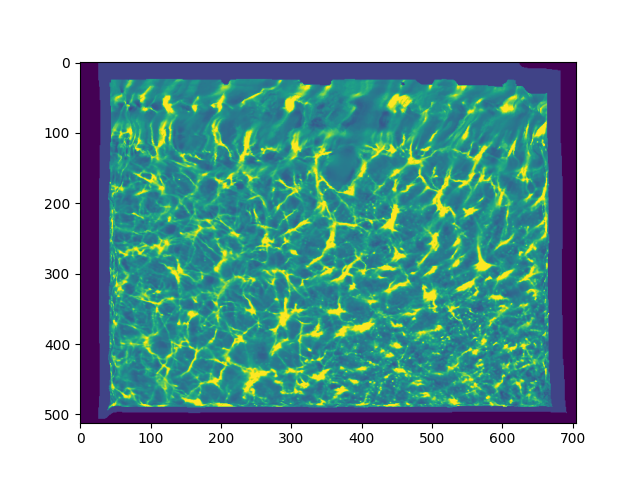

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


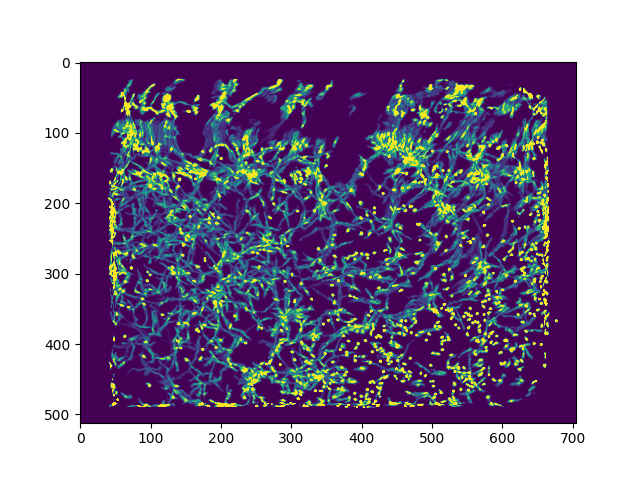

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


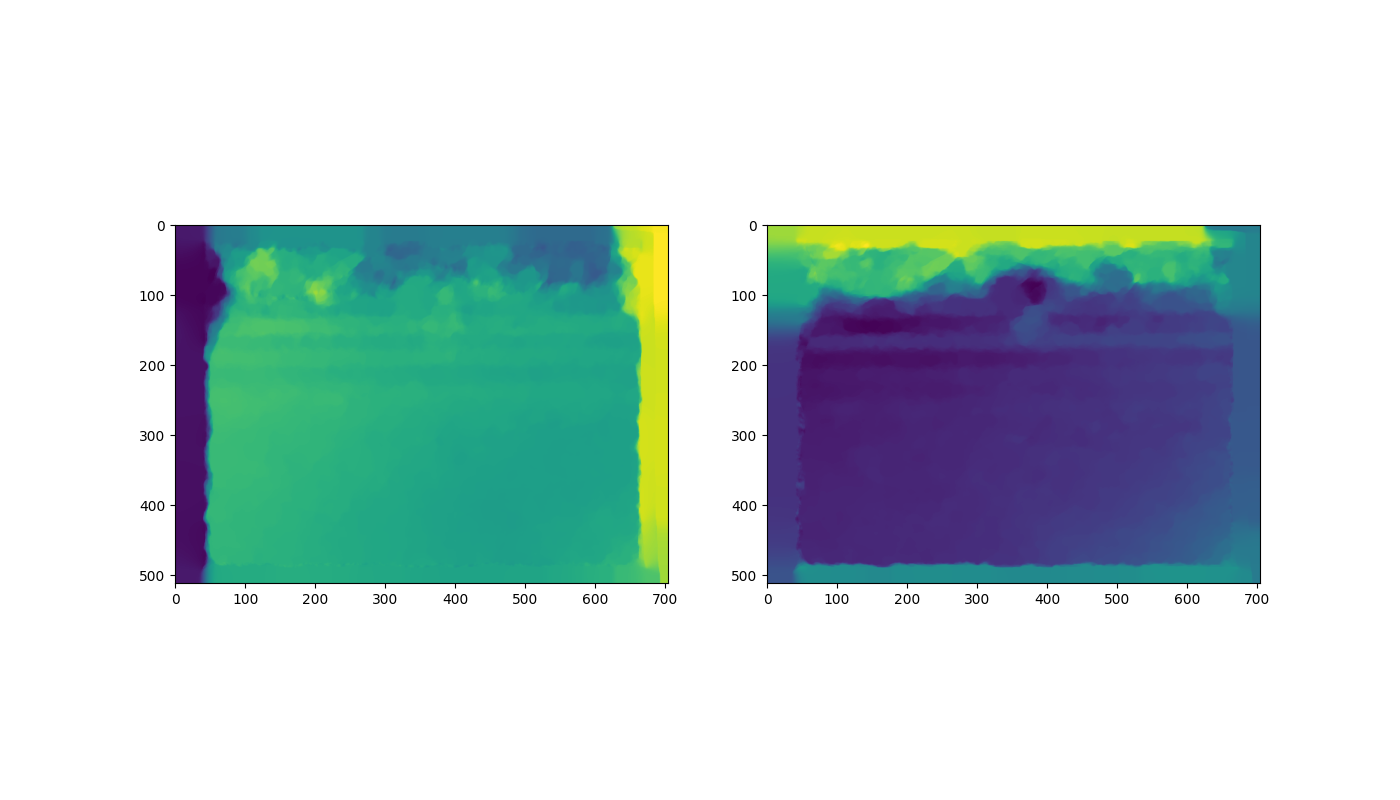

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [11]:
%matplotlib notebook
visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

In [12]:
# Blur ROIs (optional)
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=params['blurring']['kernel_halfWidth'],
    plot_kernel=params['blurring']['plot_kernel'],
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
)

# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

# Neural network embedding distances
roinet = ROInet.ROInet_embedder(
    device=params['ROInet']['device'],
    dir_networkFiles=params['ROInet']['dir_networkFiles'],
    download_from_gDrive=params['ROInet']['download_from_gDrive'],
    gDriveID=params['ROInet']['gDriveID'],
    hash_dict_networkFiles=params['ROInet']['hash_dict_true'],
    verbose=params['ROInet']['verbose'],
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=params['importing']['um_per_pixel'],
    pref_plot=params['ROInet']['pref_plot'],
    batchSize_dataloader=params['ROInet']['batchSize_dataloader'],
    pinMemory_dataloader=params['ROInet']['pinMemory_dataloader'],
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=params['ROInet']['persistentWorkers_dataloader'],
    prefetchFactor_dataloader=params['ROInet']['prefetchFactor_dataloader'],    
);

# visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


# Scattering wavelet embedding distances
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D=params['SWT']['kwargs_Scattering2D'], 
    image_shape=params['importing']['out_height_width'], 
    device=params['SWT']['device'],
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

Preparing the Toeplitz convolution matrix
Performing convolution for blurring
Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:25<00:00,  1.79s/it]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                  | 0/6397 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network
SWT initialized
Starting: SWT transform on ROIs


  0%|                                                | 0/511.69 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████| 512/511.69 [00:02<00:00, 247.15it/s]

Completed: SWT transform on ROIs


<IPython.core.display.Javascript object>


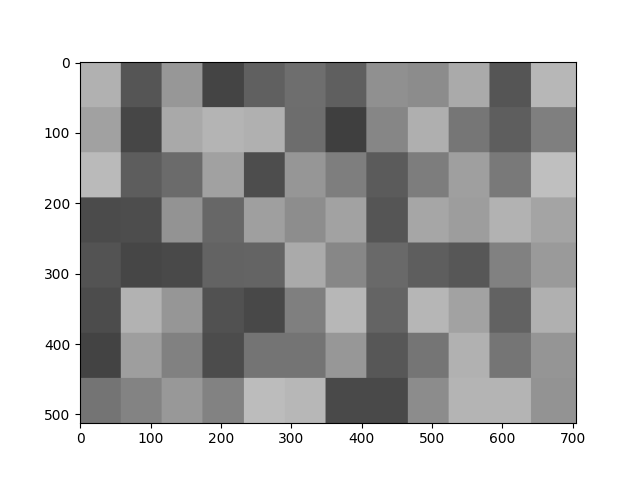

Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 96/96 [01:39<00:00,  1.03s/it]


Normalizing Neural Network similarity scores...


100%|██████████████████████████████████| 51169/51169 [00:04<00:00, 10536.83it/s]


Normalizing SWT similarity scores...


100%|████████████████████████████████████| 51169/51169 [05:14<00:00, 162.68it/s]


In [13]:
# Compute similarities
# sim = similarity_graph.ROI_graph(
#     n_workers=params['similarity']['n_workers'],
#     frame_height=data.FOV_height,
#     frame_width=data.FOV_width,
#     block_height=params['similarity']['block_height'],
#     block_width=params['similarity']['block_width'],
#     algorithm_nearestNeigbors_spatialFootprints=params['similarity']['algorithm_nearestNeigbors_spatialFootprints'],
#     verbose=params['similarity']['verbose'],
# )
sim = similarity_graph.ROI_graph(
    n_workers=params['similarity']['n_workers'],
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=64,
    block_width=64,
    algorithm_nearestNeigbors_spatialFootprints=params['similarity']['algorithm_nearestNeigbors_spatialFootprints'],
    verbose=params['similarity']['verbose'],
)

sim.visualize_blocks()

sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=params['similarity']['spatialFootprint_maskPower'],
);

sim.make_normalized_similarities(
    centers_of_mass=data.get_midCoords(),
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    k_max=params['similarity']['normalization']['k_max'],
    k_min=params['similarity']['normalization']['k_min'],
    algo_NN=params['similarity']['normalization']['algo_NN'],
)

<IPython.core.display.Javascript object>


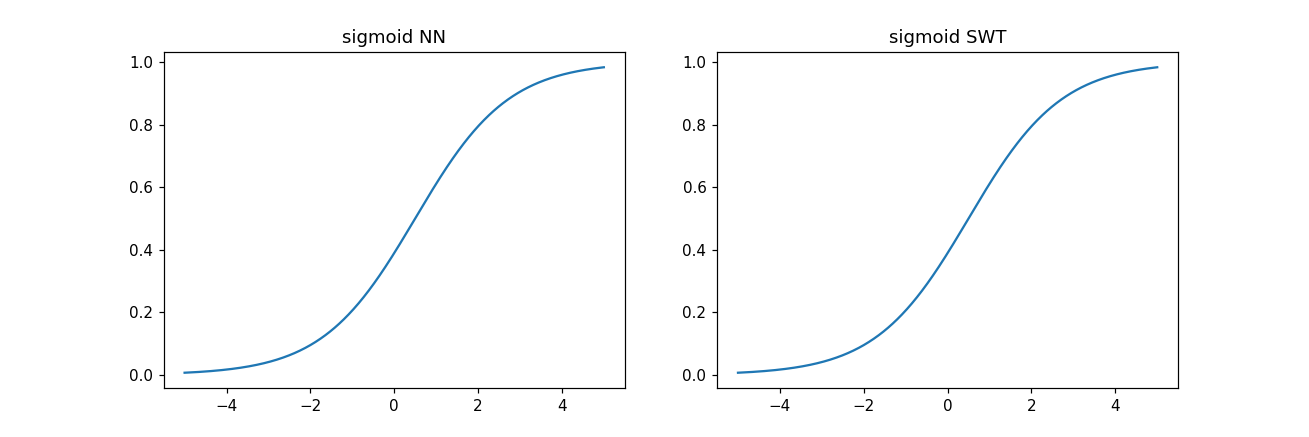

Making conjunctive distance matrix...


In [47]:
## Cluster
clusterer = clustering.Clusterer()

# clusterer.make_conjunctive_distance_matrix(
#     s_sf=sim.s_sf,
#     s_NN_z=sim.s_NN_z,
#     s_SWT_z=sim.s_SWT_z,
#     power_sf=params['clustering']['power_sf'],
#     power_NN=params['clustering']['power_NN'],
#     power_SWT=params['clustering']['power_SWT'],
#     p_norm=params['clustering']['p_norm'],
#     sig_NN_kwargs=params['clustering']['sig_NN_kwargs'],
#     sig_SWT_kwargs=params['clustering']['sig_SWT_kwargs'],
#     plot_sigmoid=params['clustering']['plot_pref'],
# )
clusterer.make_conjunctive_distance_matrix(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    power_sf=1,
    power_NN=1,
    power_SWT=0.0,
    p_norm=0,
    sig_NN_kwargs={'mu':0.5, 'b':0.9},
    sig_SWT_kwargs={'mu':0.5, 'b':0.9},
    plot_sigmoid=params['clustering']['plot_pref'],
)

<IPython.core.display.Javascript object>


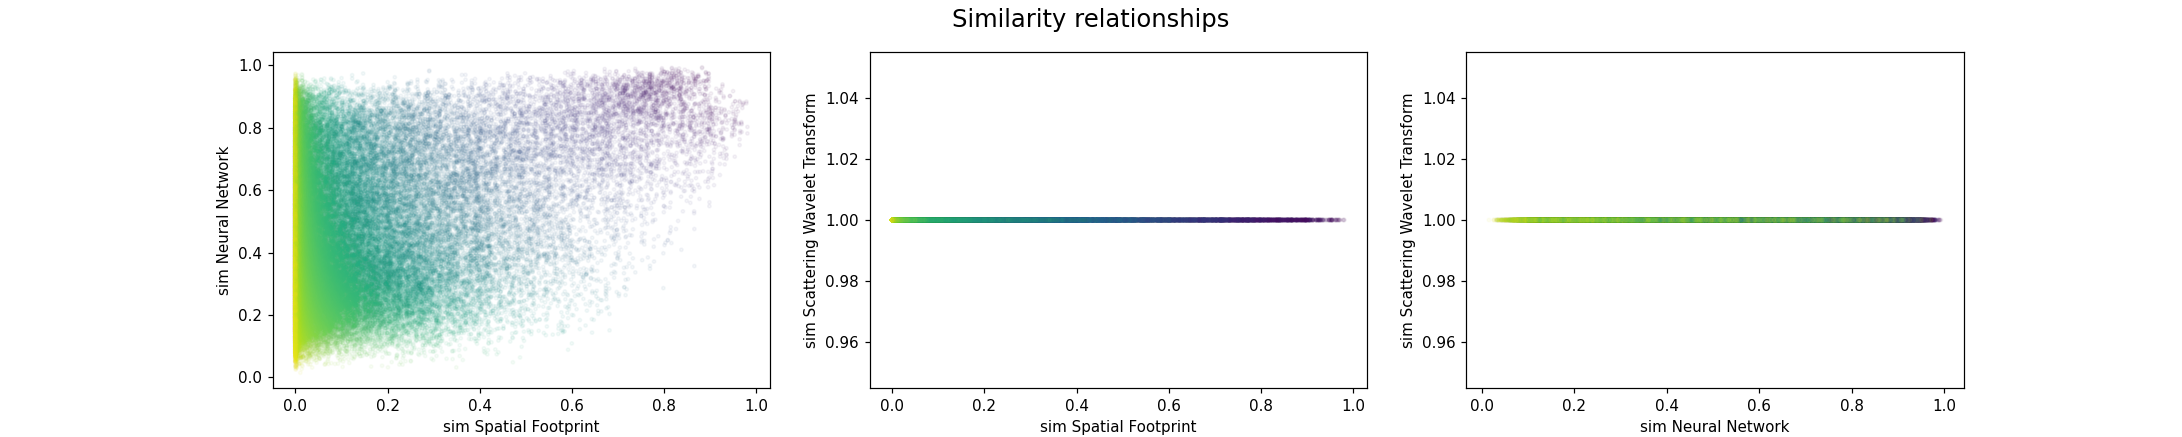

In [45]:
# %matplotlib inline
if params['clustering']['plot_pref']:
    clusterer.plot_similarity_relationships(plots_to_show=[1,2,3])

Finding intermode cutoff...


<IPython.core.display.Javascript object>


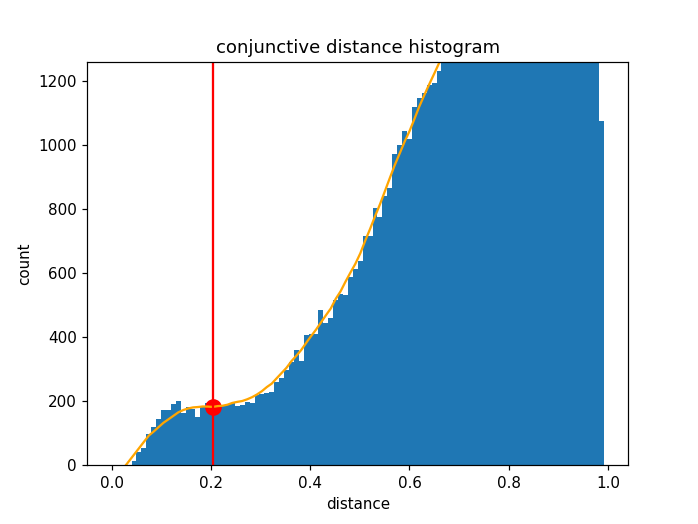

In [42]:
# clusterer.find_intermode_cutoff(
#     n_bins=params['clustering']['n_bins'],
#     smoothing_window=params['clustering']['smoothing_window'],
#     plot_pref=params['clustering']['plot_pref'],
# )
clusterer.find_intermode_cutoff(
    n_bins=params['clustering']['n_bins'],
    smoothing_window=13,
    plot_pref=params['clustering']['plot_pref'],
)

Finding intermode cutoff...


<IPython.core.display.Javascript object>


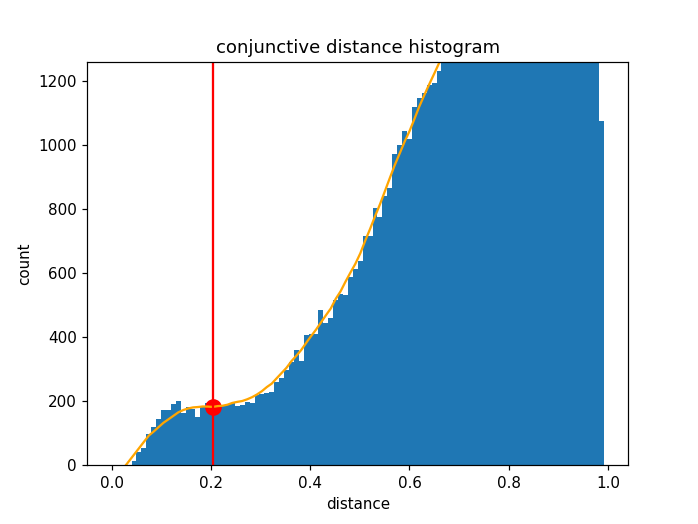

In [46]:
# clusterer.find_intermode_cutoff(
#     n_bins=params['clustering']['n_bins'],
#     smoothing_window=params['clustering']['smoothing_window'],
#     plot_pref=params['clustering']['plot_pref'],
# )
clusterer.find_intermode_cutoff(
    n_bins=params['clustering']['n_bins'],
    smoothing_window=13,
    plot_pref=params['clustering']['plot_pref'],
)

In [38]:
labels = clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=params['clustering']['min_cluster_size'],
    discard_failed_pruning=params['clustering']['discard_failed_pruning'],
);
labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Clustering...
Splitting up clusters with multiple ROIs per session...


<IPython.core.display.Javascript object>


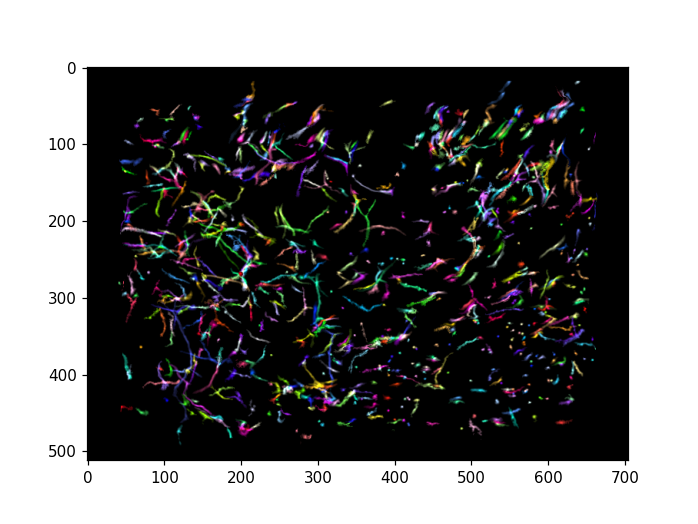

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [39]:
# visualization
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=labels,
    confidence=None,
    threshold_confidence = params['visualization']['FOV_threshold_confidence'],
#     threshold_confidence = 0.99,
)

%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

In [ ]:
## Save results
dir_save = Path(params['paths']['dir_allOuterFolders']).resolve() if params['paths']['dir_save'] is None else Path(params['paths']['dir_save']).resolve()
filenamePrefix_save = dir_allOuterFolders.name if params['paths']['filenamePrefix_save'] is None else params['paths']['filenamePrefix_save']
path_save = dir_save / (filenamePrefix_save + '.ROICaT.results' + '.pkl')

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [11]:
params['clustering']['plot_pref']

True

In [ ]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)


In [ ]:
# import numpy as np
# import scipy.sparse

# import torch_sparse as ts

# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/c_sim.npz',
#     matrix=sim.c_sim.tocsr(),
#     compressed=True
# )
# scipy.sparse.save_npz(
#     file=r'/home/rich/Desktop/cluster_bool.npz',
#     matrix=sim.cluster_bool.tocsr(),
#     compressed=True
# )
# np.save(
#     file=r'/home/rich/Desktop/scores.npy',
#     arr=sim.scores.numpy(),
# )

# c_sim = scipy.sparse.load_npz(file=r'/home/rich/Desktop/c_sim.npz').tolil()
# cluster_bool = scipy.sparse.load_npz(file=r'/home/rich/Desktop/cluster_bool.npz').tocsr()
# scores = torch.as_tensor(np.load(file=r'/home/rich/Desktop/scores.npy'), dtype=torch.float32)